### Getting the camera working

Here are some steps needed. First you need to enable the camera. In a terminal type `sudo raspi-config` and then use the arrow keys to select interface options and then enable the camera. A reboot is required.

Next we need to install the picamera Python modulg. In a terminal type the command

`sudo apt-get install python3-picamera`

Because the red led on the camera creates light inside the spectrometer, we can turn it off by adding this line in `/boot/config.txt` and rebooting

`disable_camera_led=1`

That's it.

In [2]:
import numpy as np
import io
import ipywidgets as widgets

from picamera import PiCamera
from PIL import Image, ImageDraw
from time import sleep, strftime
from IPython.display import clear_output

### Routine `takePicture()`

To make things easy, we define a routine to take an image with the Raspberry Pi Camera. The camera you have has a maximum resolution of 2592 x 1944 pixels. The options are set for the spectrometer setup. Note we rotate the image 270 degrees.

In [14]:
def takePicture(shutter):
    
    print("Initialising camera")
    camera = PiCamera()
    stream = io.BytesIO()
    try:
        # Full camera resolution is 2592 x 1944 - we run at 1/4 resolution 
        camera.resolution = (648, 486)        
        camera.framerate= 5
        camera.rotation = 270
        camera.iso = 800
        camera.shutter_speed = shutter
        camera.awb_mode = 'off'
        camera.awb_gains = (1, 1)

        print("Allowing camera to warmup")
        sleep(1)
        print("Capturing image")

        camera.capture(stream, format='jpeg')
        stream.seek(0)
        raw = Image.open(stream)
    finally:
        camera.close()
    return raw

### Trying it out

Now let's capture an image and display it. Note that the argument shutter specifies the time to expose the image in micro-seconds - so 1,000,000 is one second. the maximum exposure the camera can do is 6,000,000 or 6 seconds.

Initialising camera
Allowing camera to warmup
Capturing image


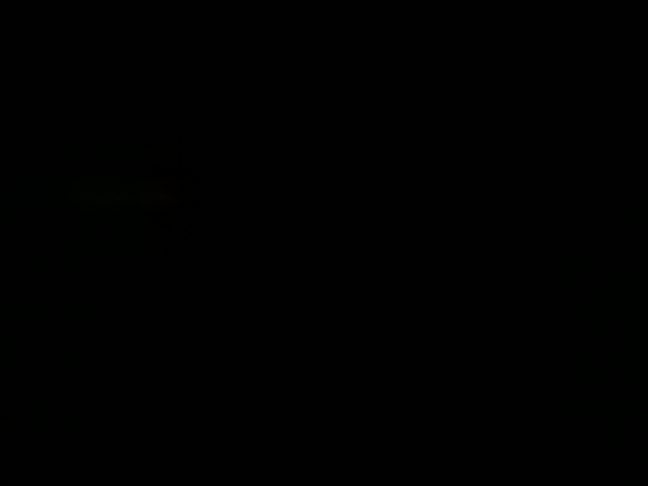

In [15]:
shutter = 100000
image = takePicture(shutter)

image  # This will show the captured image

If you see an image - woohoo 🎉🥳. You connected the camera correctly and the code is working. Try different exposure times.

### Cropping the image

Next we need to crop the image to just include the area showing the spectrum. We will first add a rectange to the image to show the current area. The crop region is given by the top left and bottom right points.

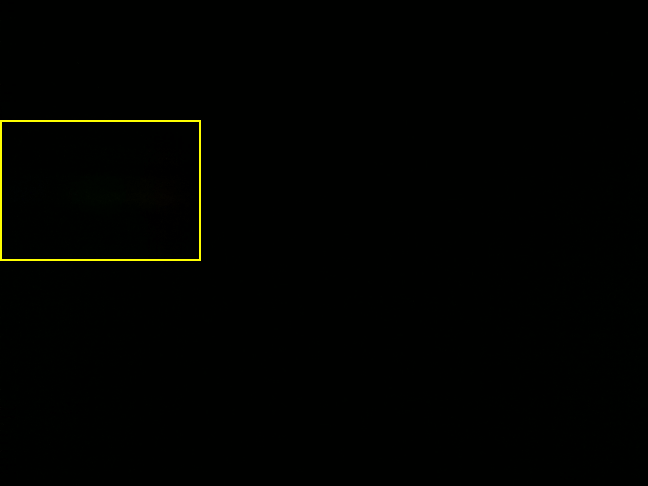

In [16]:
def drawRectangle(img,crop):
    temp = img.copy() # Making a copy to keep our raw image without the lines :)
    draw = ImageDraw.Draw(temp)
    draw.rectangle(crop, outline=(255, 255, 0), width=2)
    return temp

crop=[0,120,200,260]
tmp=drawRectangle(image,crop)
tmp

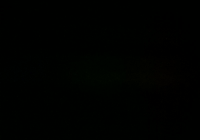

In [17]:
def imageCrop(img,crop):
    return image.crop(crop)

cropped = imageCrop(image,crop)
cropped

And here is the image we will now process and use as ouir spectrum 😎

### Making a nice interface

The package `ipywidgets` allows us to build a nice interface for our camera and later the spectrometer. Look at the comments in the code.

In [ ]:
def updateImage(img, imgWidget):
    
    # Convert to binary and update image widget
    ibytes = io.BytesIO()
    img.save(ibytes, format='JPEG')
    imgWidget.value = ibytes.getvalue()

In [ ]:
# This is the routine we call when the button is pressed
def takeImage(self):
    
    with output:
        output.clear_output()
        button.description="Please wait"
        shutter = float(exposure.value)
        img = takePicture(int(shutter * 1000000))       
        updateImage(img, imgWidget)
        button.description="Take another one"

In [ ]:
# Field to enter exposure time
exposure = widgets.Text(value='1', placeholder='', description='Exposure (s):', disabled=False)

# Field for the image
file = open("Images/Camera.png", "rb")
start = file.read()
imgWidget = widgets.Image(value=start, width=1296/4, height=972/4, format='jpg')

# Button and button callback
button = widgets.Button(description='Take picture', disabled=False, button_style='success')
button.on_click(takeImage)

# Output field for all print statements
output = widgets.Output()

# Create and show the layout
control=widgets.HBox([exposure, button])
middle=widgets.HBox([image,output])
layout=widgets.VBox([control,middle])
display(layout)

with output:
    print ("Camera ready ..")

In [44]:
labels=["xmin","xmax","ymin","ymax"]
crop=[0,120,200,260]
cropWid=[]

label=widgets.Label(value='Crop region')
for i in range(4):
    cropWid.append(widgets.BoundedIntText(description=labels[i],value=100, min=0, max=800, step=1, disabled=False))

widgets.VBox(cropWid)